# Hillsborough
Using the “processed” dataset, perform a simple correlation analysis: which ACS variables are most associated with evictions? Foreclosures? Do these two housing loss categories have any correlated variables in common?

### Imports and settings

In [130]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt 
from scipy.stats import norm 

pd.set_option('display.max_columns', None)

### Reading and cleaning the data

In [131]:
df = pd.read_csv('hillsborough_fl_processed_2017_to_2019_20210225.csv')

#dropping variable with all null values
df = df.drop(columns=['pct-below-poverty-level'])

#removing rows with negative and null values
df = df[df.select_dtypes(include=[np.number]).ge(0).all(1)]
df = df.dropna()
df = df.reset_index(drop=True)

In [132]:
df

,census_tract_GEOID,total-households,total-renter-occupied-households,total-owner-occupied-households,total-owner-occupied-households-mortgage,median-gross-rent,median-household-income,median-property-value,median-monthly-housing-cost,pct-white,pct-af-am,pct-hispanic,pct-am-indian,pct-asian,pct-nh-pi,pct-multiple,pct-other,households-children,single-parent-household,older-adult-alone,level-of-education,immigrant-status,english-fluency,drive-to-work,public-transport-to-work,vacant-properties,live-in-mobile-home,pct-renter-occupied,pct-owner-occupied,pct-owner-occupied-mortgage,pct-owner-occupied-without-mortgage,median-house-age,pct-non-white,pct-without-health-insurance,total-evictions,avg-evictions,total-foreclosure-sales,avg-foreclosure-sales,total-lien-foreclosures,avg-lien-foreclosures,total-evictions-2017,eviction-filings-2017,eviction-rate-2017,total-evictions-2018,eviction-filings-2018,eviction-rate-2018,total-evictions-2019,eviction-filings-2019,eviction-rate-2019,foreclosure-sales-2017,foreclosure-sales-2018,foreclosure-sales-2019,lien-foreclosures-2017,lien-foreclosures-2018,lien-foreclosures-2019,avg-foreclosure-rate,foreclosure-rate-2017,foreclosure-rate-2018,foreclosure-rate-2019,avg-lien-foreclosure-rate,lien-foreclosure-rate-2017,lien-foreclosure-rate-2018,lien-foreclosure-rate-2019,avg-eviction-rate,ratio-to-mean-foreclosure-rate,ratio-to-mean-eviction-rate,avg-housing-loss-rate,evictions-pct-total-housing-loss,housing-loss-index,county_GEOID,county,state
0,12057011006,1861,244,1617,1072,1349,66815,194200,1423,93.0,1.4,8.9,0.0,1.0,0.0,3.4,1.2,569,60,222,3598,65,622,2227,7,173,197,13.111231,86.888769,57.603439,29.285330,37,7.0,9.018718,18.360000,6.120000,27.0,9.000000,6.0,2.000000,7.020000,13.0,0.540000,7.020000,13.0,0.540000,4.320000,8.0,0.540000,10.0,7.0,10.0,1.0,3.0,2.0,0.839552,0.932836,0.652985,0.932836,0.123686,0.061843,0.185529,0.123686,2.508197,1.307560,1.060859,1.148936,0.404762,0.746079,12057,Hillsborough County,Florida
1,12057011203,1403,552,851,578,967,72716,235400,1484,81.3,10.3,21.7,0.0,0.6,2.9,1.3,3.6,392,102,76,2683,267,808,1579,0,230,0,39.344262,60.655738,41.197434,19.458304,44,18.7,10.713294,25.253968,8.417989,3.0,1.500000,8.0,4.000000,6.460317,11.0,0.587302,5.873016,10.0,0.587302,12.920635,22.0,0.587302,2.0,0.0,1.0,5.0,3.0,0.0,0.259516,0.346021,0.000000,0.173010,0.470035,0.587544,0.352526,0.000000,1.524998,0.404182,0.645008,0.877698,0.848760,0.569947,12057,Hillsborough County,Florida
2,12057011206,1263,676,587,343,750,33329,132500,1168,78.9,15.5,16.2,0.0,1.6,0.0,1.7,2.3,205,70,190,2057,282,744,823,90,148,361,53.523357,46.476643,27.157561,19.319082,46,21.1,21.570122,50.076923,16.692308,6.0,2.000000,3.0,1.000000,14.307692,30.0,0.476923,14.307692,30.0,0.476923,21.461538,45.0,0.476923,3.0,2.0,1.0,1.0,1.0,1.0,0.583090,0.874636,0.583090,0.291545,0.170358,0.170358,0.170358,0.170358,2.469276,0.908134,1.044397,1.834378,0.893004,1.191181,12057,Hillsborough County,Florida
3,12057011407,1126,374,752,443,1244,68906,250000,1556,97.1,0.0,17.2,0.0,1.1,0.0,0.9,1.0,125,18,245,1803,15,349,1074,18,123,0,33.214920,66.785080,39.342806,27.442274,39,2.9,9.423850,19.190476,6.396825,8.0,2.666667,5.0,1.666667,6.809524,11.0,0.619048,3.095238,5.0,0.619048,9.285714,15.0,0.619048,1.0,6.0,1.0,3.0,1.0,1.0,0.601956,0.225734,1.354402,0.225734,0.221631,0.398936,0.132979,0.132979,1.710381,0.937516,0.723417,1.109363,0.705779,0.720382,12057,Hillsborough County,Florida
4,12057011412,1427,880,547,338,1154,46458,153600,1295,87.1,3.9,29.1,0.0,2.9,0.0,1.1,5.1,328,80,174,2373,178,1090,1401,0,100,324,61.667835,38.332165,23.686055,14.646111,28,12.9,17.047452,25.817204,8.605735,9.0,3.000000,3.0,1.500000,11.064516,21.0,0.526882,6.849462,13.0,0.526882,7.903226,15.0,0.526882,4.0,3.0,2.0,0.0,1.0,2.0,0.887574,1.183432,0.887574,0.591716,0.274223,0.000000,0.182815,0.365631,0.977924,1.382351,0.413620,0.952852,0.741507,0.618749,12057,Hillsborough County,Florida
5,12057011509,2069,124,1945,1571,2642,100512,340700,2219,92.0,4.5,9.8,0.0,2.1,0.0,0.0,1.4

### Computing overall correlation to check for redundant/linked variables

<AxesSubplot:>

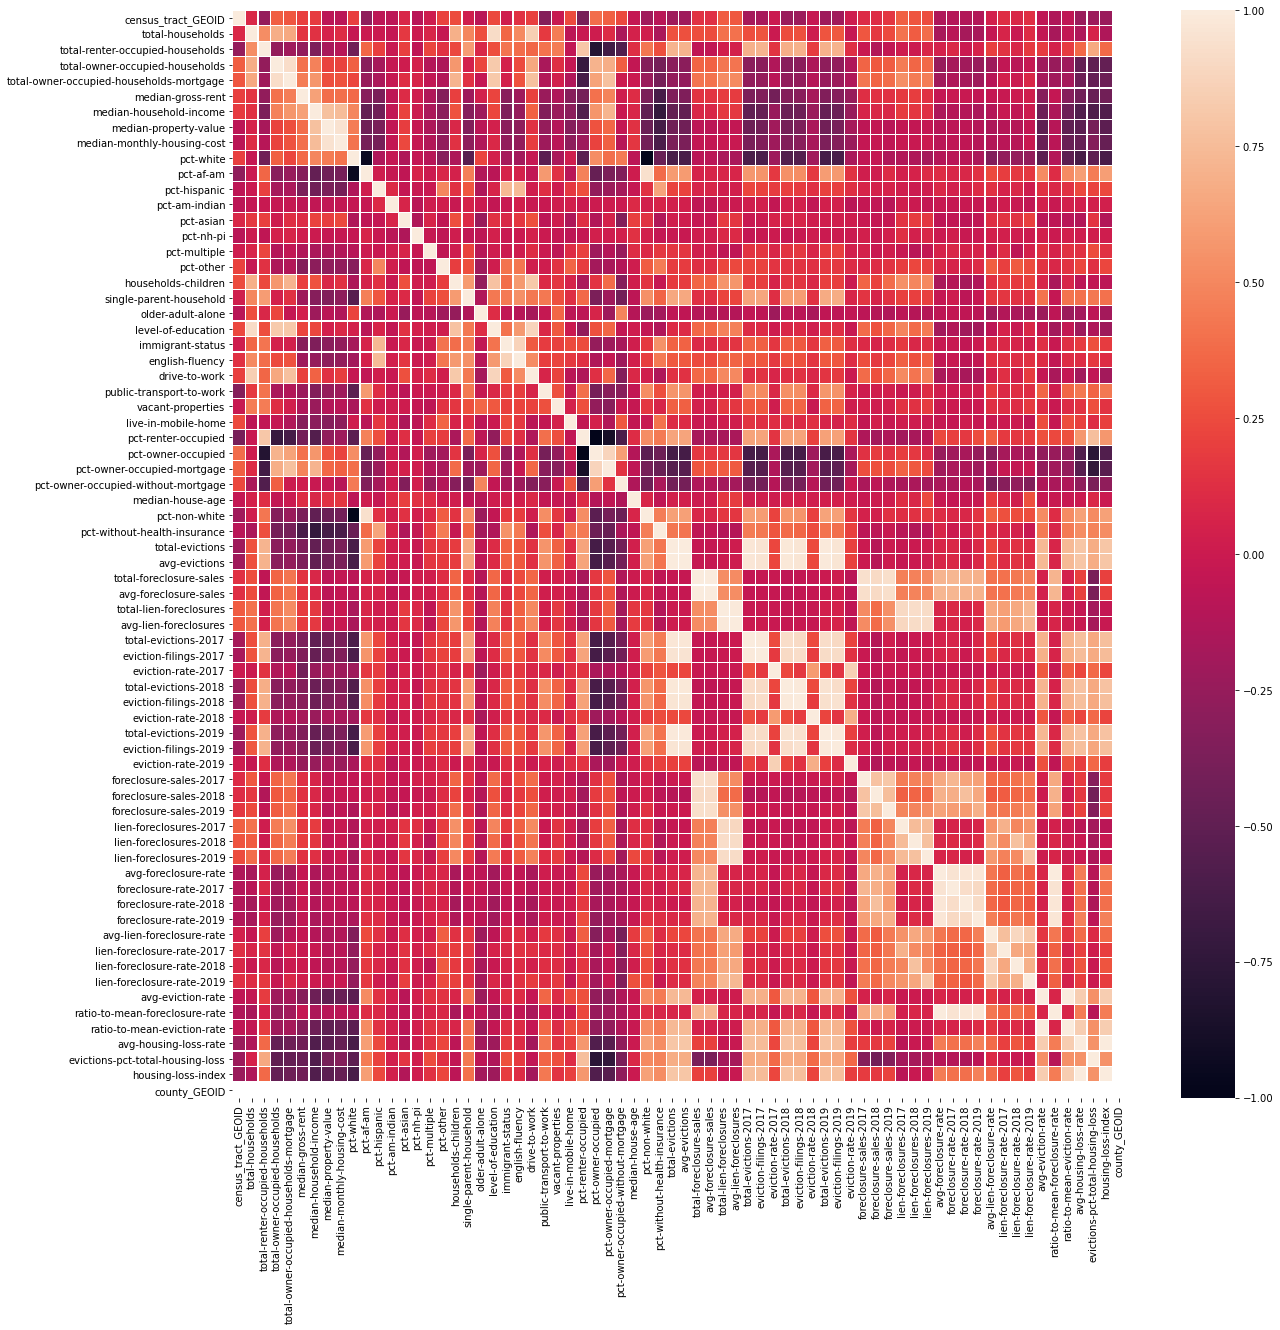

In [133]:
#generating heatmap of correlations between all variables
corrmat = df.corr() 
f, ax = plt.subplots(figsize =(20, 20)) 
sns.heatmap(corrmat, ax = ax, linewidths = 0.1) 

In [134]:
#removing redundant variables
toDrop = ['census_tract_GEOID', 'total-renter-occupied-households', 'total-owner-occupied-households', 'total-owner-occupied-households-mortgage', 'county_GEOID', 'county', 'state']
df = df.drop(columns = toDrop)

In [135]:
#Changing variables listing totals into percentages
df['pct-households-with-children'] = (df['households-children'] / df['total-households']) * 100
df['pct-single-parent'] = (df['single-parent-household'] / df['total-households']) * 100
df['pct-older-adult-alone'] = (df['older-adult-alone'] / df['total-households']) * 100
df['pct-live-in-mobile-home'] = (df['live-in-mobile-home'] / df['total-households']) * 100
df = df.drop(columns = ['households-children', 'single-parent-household', 'older-adult-alone', 'live-in-mobile-home'])

In [136]:
#lists of relevant variables
acsVariables = ['census_tract_GEOID', 'total-households', 'median-gross-rent', 'median-household-income', 'median-property-value', 'median-monthly-housing-cost', 'pct-white', 'pct-af-am', 'pct-hispanic', 'pct-am-indian', 'pct-asian', 'pct-nh-pi', 'pct-multiple', 'pct-other', 'level-of-education', 'immigrant-status', 'english-fluency', 'drive-to-work', 'public-transport-to-work', 'vacant-properties', 'pct-renter-occupied', 'pct-owner-occupied', 'pct-owner-occupied-mortgage', 'pct-owner-occupied-without-mortgage', 'median-house-age', 'pct-non-white', 'pct-without-health-insurance', 'avg-housing-loss-rate', 'housing-loss-index', 'pct-households-with-children', 'pct-single-parent', 'pct-older-adult-alone', 'pct-live-in-mobile-home']
evictions = ['total-evictions', 'avg-evictions', 'total-evictions-2017', 'eviction-filings-2017', 'eviction-rate-2017', 'total-evictions-2018', 'eviction-filings-2018', 'eviction-rate-2018', 'total-evictions-2019', 'eviction-filings-2019', 'eviction-rate-2019', 'avg-eviction-rate', 'ratio-to-mean-eviction-rate', 'evictions-pct-total-housing-loss']
foreclosures = ['total-foreclosure-sales', 'avg-foreclosure-sales', 'total-lien-foreclosures', 'avg-lien-foreclosures', 'foreclosure-sales-2017', 'foreclosure-sales-2018', 'foreclosure-sales-2019', 'lien-foreclosures-2017', 'lien-foreclosures-2018', 'lien-foreclosures-2019', 'avg-foreclosure-rate', 'foreclosure-rate-2017', 'foreclosure-rate-2018', 'foreclosure-rate-2019', 'avg-lien-foreclosure-rate', 'lien-foreclosure-rate-2017', 'lien-foreclosure-rate-2018', 'lien-foreclosure-rate-2019', 'ratio-to-mean-foreclosure-rate']

### Computing correlations for evictions

<AxesSubplot:>

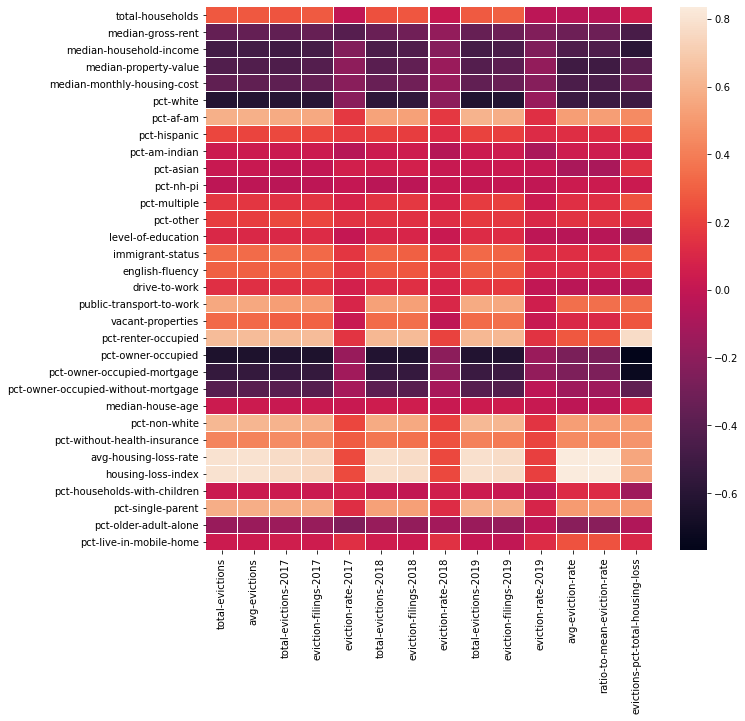

In [137]:
#using pearson correlation
evictionsDf = df.drop(columns=foreclosures)
evictionsMat = evictionsDf.corr().filter(evictions).drop(evictions)
f, ax = plt.subplots(figsize =(10, 10)) 
sns.heatmap(evictionsMat, ax = ax, linewidths = 0.1) 

#### Inference
<ul>
<li>Percentage of homes occupied by owners with and without mortages - these two variables have a strong negative correlation with evictions, implying that areas with larger percentages of people owning their own homes have lower eviction rates.</li>

<li>Median gross rent, household income, property value, monthly housing costs, percentage of white households - these variables have a positive correlation with evictions, implying that areas with higher costs of living and predominantly white areas have lower eviction rates.</li>

<li>Percentage single parents, percentage of non-white households, percentage of African American households, public transport to work - these variables have a positive correlation with evictions, implying that areas with higher percentages of these households have higher eviction rates.</li>
</ul>

### Computing correlations for foreclosures

<AxesSubplot:>

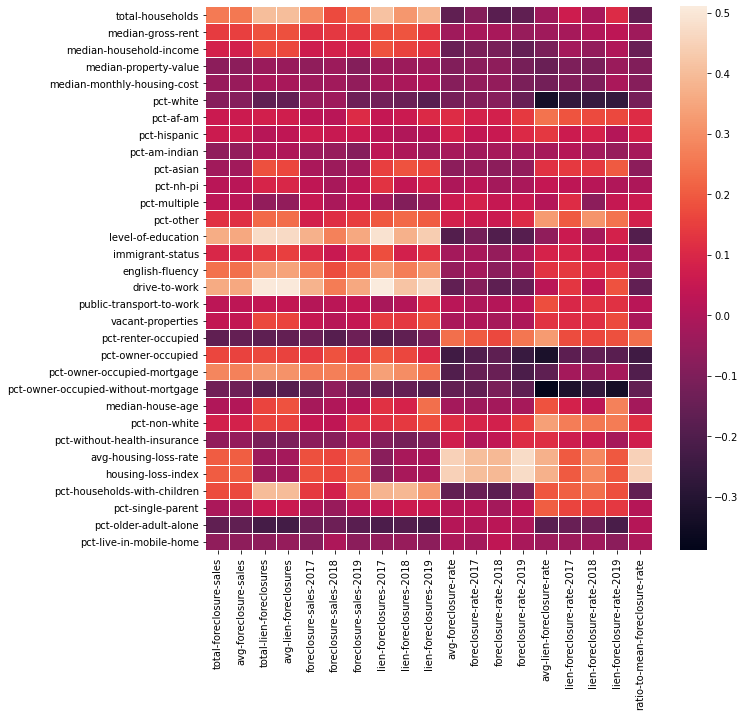

In [139]:
#using pearson correlation
foreclosuresDf = df.drop(columns=evictions)
foreclosuresMat = foreclosuresDf.corr().filter(foreclosures).drop(foreclosures)
f, ax = plt.subplots(figsize =(10, 10)) 
sns.heatmap(foreclosuresMat, ax = ax, linewidths = 0.1) 

#### Inference
<ul>
<li>Percentage of households with children, drive to work, level of education - these variables have a strong positive correlation with lien foreclosures, implying that areas with higher percentages of these populations have higher rates of lien foreclosure. However, it should be noted that these variables are negatively correlated to average foreclosure rate, implying that although the lien rates are high, actual foreclosure sales rates in these areas are low.</li>
<li>Percentage owner occupied with and without mortages - these variables are positively correlated with lien foreclosures adn foreclosure sales but not foreclosure rates, implying that areas with higher percentages of home owners have lower foreclosure rates, but still have high rates of lien and foreclosure sales.</li>
<li>Percentage older adult living alone - this variable has a strong negative correlation with all forms of foreclosure, implying that areas with larger percentages of households consisting of a single old aduly have lower foreclosure rates.</li>
</ul>

### Commonalities 
There aren't any solid commonalities between eviction rates and foreclosure rates on the basis of this dataset.

### Limitations and further work
Because of the large number of null values, less than 200 data points are considered. This may not be enough to capture significant trends. Further exploration of trends could be done by expanding the dataset adn including more ACS variables, such as Josh Hirner's dataset <a href="https://github.com/datakind/Mar21-housing-insecurity/blob/main/data/processed/hillsborough_fl_processed_expanded_ACS_2017_to_2019_20210225.csv">here</a>.